# 静的銘柄エントリータイミング分析
## 目的: スイング最適タイミングの特定

- どのタイミングでエントリーすべきか？
- マーケット環境との関係
- テクニカル指標との相関
- 曜日・時間帯による傾向

In [1]:
import sys
from pathlib import Path

# grok_trending_performance ディレクトリ
GROK_DIR = Path.cwd().parent
SCRIPTS_DIR = GROK_DIR / 'scripts'

if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

# プロジェクトルート（dash_plotly）
ROOT = GROK_DIR.parent.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 日本語フォント設定を最優先で適用
matplotlib.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# matplotlibのフォントキャッシュをクリア
fm._load_fontmanager(try_read_cache=False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

from load_data import DataLoader

loader = DataLoader()
print("✓ ライブラリ読み込み完了")
print(f"✓ 使用フォント: {plt.rcParams['font.sans-serif'][0]}")

Matplotlib is building the font cache; this may take a moment.


✓ ライブラリ読み込み完了
✓ 使用フォント: Arial


## 1. データ読み込み

In [2]:
# 静的銘柄リストの取得
all_stocks = loader.load_all_stocks()

# Grok銘柄を除外して静的銘柄を特定
if 'source' in all_stocks.columns:
    static_stocks = all_stocks[all_stocks['source'] != 'grok_trending']
else:
    # sourceカラムがない場合は全銘柄を静的銘柄とする
    static_stocks = all_stocks.copy()

print(f"静的銘柄数: {len(static_stocks)}")
print(f"\nカラム: {static_stocks.columns.tolist()}")

# 株価データ読み込み（日足）
prices_1d = loader.load_stock_prices('1d')
print(f"\n株価データ: {len(prices_1d)} rows")

# 静的銘柄のみに絞り込み
static_tickers = static_stocks['ticker'].tolist()
static_prices = prices_1d[prices_1d['ticker'].isin(static_tickers)].copy()
print(f"静的銘柄の株価データ: {len(static_prices)} rows")

✓ All stocks loaded: 68 stocks
静的銘柄数: 68

カラム: ['ticker', 'code', 'stock_name', 'market', 'sectors', 'series', 'topixnewindexseries', 'categories', 'tags', 'date', 'Close', 'change_pct', 'Volume', 'vol_ratio', 'atr14_pct', 'rsi14', 'score', 'key_signal']
✓ Stock prices loaded: 450432 rows, interval=1d

株価データ: 450432 rows
静的銘柄の株価データ: 450432 rows


## 2. リターン計算（1日・3日・5日）

In [3]:
# 日付でソート
static_prices['date'] = pd.to_datetime(static_prices['date'])
static_prices = static_prices.sort_values(['ticker', 'date'])

# ティッカー別にリターン計算
static_prices['return_1d'] = static_prices.groupby('ticker')['Close'].pct_change(1, fill_method=None) * 100
static_prices['return_3d'] = static_prices.groupby('ticker')['Close'].pct_change(3, fill_method=None) * 100
static_prices['return_5d'] = static_prices.groupby('ticker')['Close'].pct_change(5, fill_method=None) * 100

# 基礎統計
print("【リターン基礎統計】")
print(static_prices[['return_1d', 'return_3d', 'return_5d']].describe())

【リターン基礎統計】
           return_1d      return_3d      return_5d
count  370368.000000  370232.000000  370096.000000
mean        0.105195       0.318865       0.528905
std        28.578805      49.793755      63.877345
min      -820.895275    -820.895275    -812.049955
25%        -1.140686      -1.994538      -2.555916
50%         0.000000       0.000000       0.149241
75%         1.163083       2.166442       2.890235
max     17295.263549   18090.474207   18090.474207


## 3. マーケット環境の分類

In [4]:
# 日経平均データ読み込み
index_prices = loader.load_index_prices('1d')
nikkei = index_prices[index_prices['ticker'] == '^N225'].copy()
nikkei['date'] = pd.to_datetime(nikkei['date'])
nikkei = nikkei.sort_values('date')

# 日経平均のリターン計算
nikkei['nikkei_return_1d'] = nikkei['Close'].pct_change(1, fill_method=None) * 100

# 移動平均（5日・25日）
nikkei['ma5'] = nikkei['Close'].rolling(5).mean()
nikkei['ma25'] = nikkei['Close'].rolling(25).mean()

# トレンド判定
nikkei['trend'] = '横ばい'
nikkei.loc[nikkei['Close'] > nikkei['ma25'], 'trend'] = '上昇'
nikkei.loc[nikkei['Close'] < nikkei['ma25'], 'trend'] = '下降'

# ボラティリティ（直近20日の標準偏差）
nikkei['volatility'] = nikkei['nikkei_return_1d'].rolling(20).std()

# 静的銘柄データとマージ
static_with_market = static_prices.merge(
    nikkei[['date', 'nikkei_return_1d', 'trend', 'volatility']], 
    on='date', 
    how='left'
)

print("【マーケット環境分類】")
print(static_with_market['trend'].value_counts())

✓ Index prices loaded: 149770 rows, interval=1d
【マーケット環境分類】
trend
上昇     238476
下降     182920
横ばい     21556
Name: count, dtype: int64


## 4. エントリータイミングパターン分析

【曜日別パフォーマンス】
          return_1d               return_3d        return_5d       
               mean    std  count      mean    std      mean    std
weekday                                                            
Monday         0.03   4.29  70066      0.33  61.84      0.51  64.80
Tuesday        0.10   2.64  74636      0.17   5.63      0.53  65.68
Wednesday      0.07   2.62  75180      0.21   5.58      0.50  59.17
Thursday       0.28  63.18  75078      0.49  66.21      0.57  66.40
Friday         0.04   2.64  75408      0.40  64.79      0.54  63.16


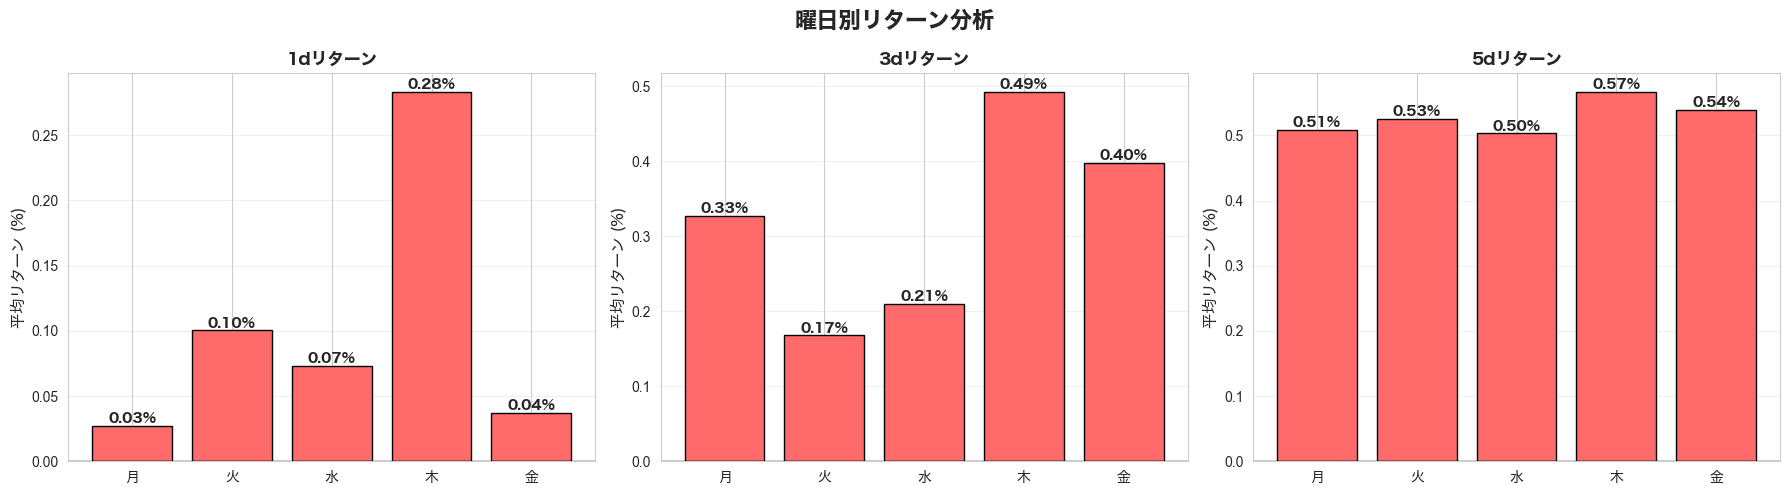

In [5]:
# 曜日別パフォーマンス
static_with_market['weekday'] = static_with_market['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

weekday_perf = static_with_market.groupby('weekday').agg({
    'return_1d': ['mean', 'std', 'count'],
    'return_3d': ['mean', 'std'],
    'return_5d': ['mean', 'std']
}).round(2)

print("【曜日別パフォーマンス】")
weekday_perf_sorted = weekday_perf.reindex(weekday_order)
print(weekday_perf_sorted)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('曜日別リターン分析', fontsize=16, fontweight='bold', fontfamily='Hiragino Sans')

for idx, (period, ax) in enumerate(zip(['return_1d', 'return_3d', 'return_5d'], axes)):
    weekday_avg = static_with_market.groupby('weekday')[period].mean().reindex(weekday_order)
    colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in weekday_avg.values]
    
    ax.bar(range(len(weekday_avg)), weekday_avg.values, color=colors, edgecolor='black')
    ax.set_xticks(range(len(weekday_avg)))
    ax.set_xticklabels(['月', '火', '水', '木', '金'], fontfamily='Hiragino Sans')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('平均リターン (%)', fontsize=11, fontfamily='Hiragino Sans')
    ax.set_title(f'{period.replace("return_", "")}リターン', fontsize=12, fontweight='bold', fontfamily='Hiragino Sans')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 数値ラベル
    for i, v in enumerate(weekday_avg.values):
        ax.text(i, v, f'{v:.2f}%', ha='center', 
               va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold', fontfamily='Hiragino Sans')

plt.tight_layout()
plt.savefig('../outputs/figures/static_weekday_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. マーケットトレンド別エントリー分析

【マーケットトレンド別パフォーマンス】
      return_1d                return_3d        return_5d       
           mean    std   count      mean    std      mean    std
trend                                                           
上昇         0.43  39.00  197859      1.26  67.91      2.05  87.09
下降        -0.31   3.02  147842     -0.91   5.84     -1.46   7.56
横ばい        0.04   2.10   19808      0.13   3.74      0.20   4.90


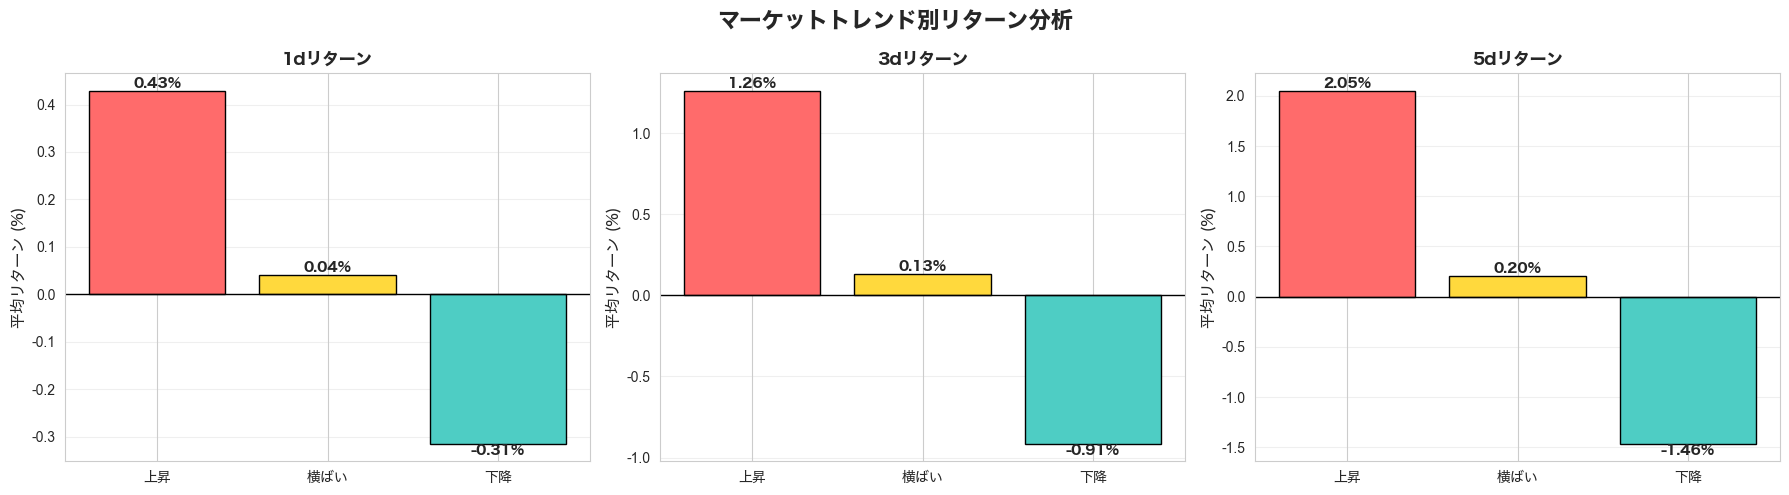

In [6]:
# トレンド別パフォーマンス
trend_perf = static_with_market.groupby('trend').agg({
    'return_1d': ['mean', 'std', 'count'],
    'return_3d': ['mean', 'std'],
    'return_5d': ['mean', 'std']
}).round(2)

print("【マーケットトレンド別パフォーマンス】")
print(trend_perf)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('マーケットトレンド別リターン分析', fontsize=16, fontweight='bold', fontfamily='Hiragino Sans')

trends = ['上昇', '横ばい', '下降']
trend_colors = {'上昇': '#FF6B6B', '横ばい': '#FFD93D', '下降': '#4ECDC4'}

for idx, (period, ax) in enumerate(zip(['return_1d', 'return_3d', 'return_5d'], axes)):
    trend_avg = static_with_market.groupby('trend')[period].mean().reindex(trends)
    colors = [trend_colors.get(t, 'gray') for t in trends]
    
    ax.bar(range(len(trend_avg)), trend_avg.values, color=colors, edgecolor='black')
    ax.set_xticks(range(len(trend_avg)))
    ax.set_xticklabels(trends, fontfamily='Hiragino Sans')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('平均リターン (%)', fontsize=11, fontfamily='Hiragino Sans')
    ax.set_title(f'{period.replace("return_", "")}リターン', fontsize=12, fontweight='bold', fontfamily='Hiragino Sans')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 数値ラベル
    for i, v in enumerate(trend_avg.values):
        if not np.isnan(v):
            ax.text(i, v, f'{v:.2f}%', ha='center', 
                   va='bottom' if v > 0 else 'top', fontsize=10, fontweight='bold', fontfamily='Hiragino Sans')

plt.tight_layout()
plt.savefig('../outputs/figures/static_trend_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. ボラティリティ別エントリー分析

【ボラティリティ別パフォーマンス】
             return_1d                return_3d        return_5d        
                  mean    std   count      mean    std      mean     std
vol_category                                                            
低ボラ               0.23  49.75  121374      0.71  86.69      1.20  111.20
中ボラ               0.00   2.53  113408      0.09   4.55      0.22    6.07
高ボラ               0.09   3.41  112919      0.17   5.89      0.18    7.53


/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_11511/791276494.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_perf = static_with_market.groupby('vol_category').agg({
/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_11511/791276494.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_1d = static_with_market.groupby('vol_category')['return_1d'].mean().reindex(vol_cats)
/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_11511/791276494.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

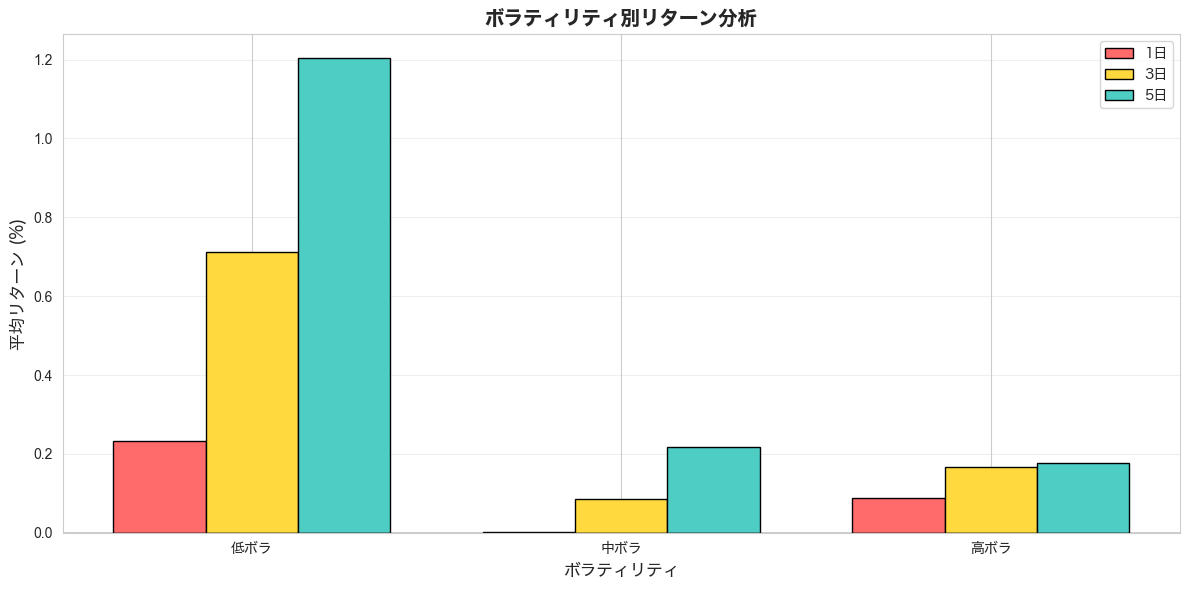

In [7]:
# ボラティリティを3分位に分割
static_with_market['vol_category'] = pd.qcut(
    static_with_market['volatility'], 
    q=3, 
    labels=['低ボラ', '中ボラ', '高ボラ'],
    duplicates='drop'
)

vol_perf = static_with_market.groupby('vol_category').agg({
    'return_1d': ['mean', 'std', 'count'],
    'return_3d': ['mean', 'std'],
    'return_5d': ['mean', 'std']
}).round(2)

print("【ボラティリティ別パフォーマンス】")
print(vol_perf)

# 可視化
fig, ax = plt.subplots(figsize=(12, 6))

vol_cats = ['低ボラ', '中ボラ', '高ボラ']
x = np.arange(len(vol_cats))
width = 0.25

returns_1d = static_with_market.groupby('vol_category')['return_1d'].mean().reindex(vol_cats)
returns_3d = static_with_market.groupby('vol_category')['return_3d'].mean().reindex(vol_cats)
returns_5d = static_with_market.groupby('vol_category')['return_5d'].mean().reindex(vol_cats)

ax.bar(x - width, returns_1d, width, label='1日', color='#FF6B6B', edgecolor='black')
ax.bar(x, returns_3d, width, label='3日', color='#FFD93D', edgecolor='black')
ax.bar(x + width, returns_5d, width, label='5日', color='#4ECDC4', edgecolor='black')

ax.set_xlabel('ボラティリティ', fontsize=12, fontfamily='Hiragino Sans')
ax.set_ylabel('平均リターン (%)', fontsize=12, fontfamily='Hiragino Sans')
ax.set_title('ボラティリティ別リターン分析', fontsize=14, fontweight='bold', fontfamily='Hiragino Sans')
ax.set_xticks(x)
ax.set_xticklabels(vol_cats, fontfamily='Hiragino Sans')
ax.legend(fontsize=11, prop={'family': 'Hiragino Sans'})
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/static_volatility_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 最適エントリータイミングの提案

In [8]:
print("="*80)
print("最適エントリータイミングの提案")
print("="*80)

# 曜日別最高リターン
best_weekday_1d = weekday_avg.idxmax()
best_weekday_val = weekday_avg.max()

print(f"\n【1. 曜日】")
print(f"最適: {best_weekday_1d} (平均リターン: {best_weekday_val:.2f}%)")

# トレンド別最高リターン
trend_avg_5d = static_with_market.groupby('trend')['return_5d'].mean()
best_trend = trend_avg_5d.idxmax()
best_trend_val = trend_avg_5d.max()

print(f"\n【2. マーケットトレンド】")
print(f"最適: {best_trend}トレンド (5日平均リターン: {best_trend_val:.2f}%)")

# ボラティリティ別最高リターン
vol_avg_5d = static_with_market.groupby('vol_category')['return_5d'].mean()
best_vol = vol_avg_5d.idxmax()
best_vol_val = vol_avg_5d.max()

print(f"\n【3. ボラティリティ】")
print(f"最適: {best_vol} (5日平均リターン: {best_vol_val:.2f}%)")

# 組み合わせ条件
print(f"\n【4. 推奨エントリー条件】")
print(f"   - 曜日: {best_weekday_1d}")
print(f"   - トレンド: {best_trend}")
print(f"   - ボラティリティ: {best_vol}")

# 組み合わせでフィルタ
optimal_condition = static_with_market[
    (static_with_market['weekday'] == best_weekday_1d) &
    (static_with_market['trend'] == best_trend) &
    (static_with_market['vol_category'] == best_vol)
]

if len(optimal_condition) > 0:
    print(f"\n【組み合わせ条件でのパフォーマンス】")
    print(f"   サンプル数: {len(optimal_condition)}")
    print(f"   1日平均リターン: {optimal_condition['return_1d'].mean():.2f}%")
    print(f"   3日平均リターン: {optimal_condition['return_3d'].mean():.2f}%")
    print(f"   5日平均リターン: {optimal_condition['return_5d'].mean():.2f}%")
else:
    print(f"\n⚠️ 組み合わせ条件に該当するデータなし")

print("\n" + "="*80)

最適エントリータイミングの提案

【1. 曜日】
最適: Thursday (平均リターン: 0.57%)

【2. マーケットトレンド】
最適: 上昇トレンド (5日平均リターン: 2.05%)

【3. ボラティリティ】
最適: 低ボラ (5日平均リターン: 1.20%)

【4. 推奨エントリー条件】
   - 曜日: Thursday
   - トレンド: 上昇
   - ボラティリティ: 低ボラ

【組み合わせ条件でのパフォーマンス】
   サンプル数: 19856
   1日平均リターン: 1.22%
   3日平均リターン: 1.70%
   5日平均リターン: 2.30%



/var/folders/lc/9gc67bcn35g9t21r_pbch1t80000gn/T/ipykernel_11511/3473981343.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_avg_5d = static_with_market.groupby('vol_category')['return_5d'].mean()


## 8. レポート出力

In [9]:
# サマリーレポート
summary_data = {
    '最適曜日': best_weekday_1d,
    '最適曜日リターン(%)': best_weekday_val,
    '最適トレンド': best_trend,
    '最適トレンドリターン(%)': best_trend_val,
    '最適ボラティリティ': best_vol,
    '最適ボラリターン(%)': best_vol_val,
}

summary_df = pd.DataFrame([summary_data])
summary_df.to_csv('../outputs/reports/static_entry_timing_summary.csv', index=False)

# 詳細データ保存
weekday_perf.to_csv('../outputs/reports/static_weekday_performance.csv')
trend_perf.to_csv('../outputs/reports/static_trend_performance.csv')
vol_perf.to_csv('../outputs/reports/static_volatility_performance.csv')

print("✓ レポート保存完了:")
print("  - outputs/reports/static_entry_timing_summary.csv")
print("  - outputs/reports/static_weekday_performance.csv")
print("  - outputs/reports/static_trend_performance.csv")
print("  - outputs/reports/static_volatility_performance.csv")
print("\n✓ グラフ保存完了:")
print("  - outputs/figures/static_weekday_performance.png")
print("  - outputs/figures/static_trend_performance.png")
print("  - outputs/figures/static_volatility_performance.png")

✓ レポート保存完了:
  - outputs/reports/static_entry_timing_summary.csv
  - outputs/reports/static_weekday_performance.csv
  - outputs/reports/static_trend_performance.csv
  - outputs/reports/static_volatility_performance.csv

✓ グラフ保存完了:
  - outputs/figures/static_weekday_performance.png
  - outputs/figures/static_trend_performance.png
  - outputs/figures/static_volatility_performance.png
